# 9.8.2 Income Redistribution Model

Agent p's reward is, $u_p(s_p - x_p) = \frac{(s_p - x_p)^{1-\alpha_p}}{1-\alpha_p}$
,where $s_p$ is a predetermined level of wealth and $x_p$ is the amount of investment.

Wealth evolution is, $h_p(x_{p, t}, \epsilon_{p,t+1}) = \gamma_p x_{p,t} + \epsilon_{p,t+1} x_{p,t}^{\beta_p}$

Then the realized wealth for agent p at time t+1 is, $s_{p, t+1} = (1 - \psi) h_p(x_{p, t}, \epsilon_{p,t+1}) + \psi h_q(x_{q, t}, \epsilon_{q,t+1})$
,where $\psi$ is the pre-determined wealth share rate between the players.

Consider two players case, each denoted by 1 and 2, who live forever. 

The time independent state transition function is defined as follows.

$g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2) = ((1 - \psi) h_1(x_1, \epsilon_1)+ \psi h_2(x_2, \epsilon_2),\ (1 - \psi) h_2(x_2, \epsilon_2)+ \psi h_1(x_1, \epsilon_1))$

Using the above functions, and defining $V_p$ as the value functions, we can set the system of Bellman equations as follows.

$\begin{cases} V_1(s_1, s_2) = \max_{0\leq x_1\leq s_1} \left\{ u_1(s_1 - x_1) + \delta E_{\epsilon}\left[ V_1(g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2)) \right] \right\}\\[10pt]
V_2(s_1, s_2) = \max_{0\leq x_2\leq s_2} \left\{ u_2(s_2 - x_2) + \delta E_{\epsilon}\left[ V_2(g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2)) \right] \right\}
\end{cases}$

I solve the above systems of functional equations by using collocation method, which means searching the Markov perfect equilibrium in this model.

In [10]:
using BasisMatrices
using QuantEcon
using PyPlot

In [11]:
# set environment
n = 15
smin = 3
smax = 11
maxit = 1000
num_nodes = 3
tol = 0.0001
srand(1234)

# make collocation matrix
sgrid0 = linspace(smin, smax, n)
basis = Basis(SplineParams(sgrid0, 0, 3), SplineParams(sgrid0, 0, 3))
S, (coordx, coordy) = nodes(basis)
Φ = BasisMatrix(basis, Expanded(), S, 0)

BasisMatrix{BasisMatrices.Expanded} of order [0 0]

In [12]:
# set model type
mutable struct IRG
    alpha::Array{Float64,1}
    beta::Array{Float64,1}
    gamma::Array{Float64,1}
    sigma::Array{Float64, 1}
    psi::Float64
    delta::Float64
end

# functions in this model
# vector valued functions
function u(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return ((s[:, p] - x[:, p]).^(1 - model.alpha[p]))./(1 - model.alpha[p])
end

function h(model::IRG, x::Array{Float64, 2}, epsilon::Float64, p::Int64)
    return model.gamma[p] * x[:, p] + epsilon * (x[:, p].^(model.beta[p]))
end

function s(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1})
    box = zeros((size(x)[1], 2))
    box[:, 1] = (1 - model.psi)*h(model, x, epsilon[1], 1) + model.psi*h(model, x, epsilon[2], 2)
    box[:, 2] = (1 - model.psi)*h(model, x, epsilon[2], 2) + model.psi*h(model, x, epsilon[1], 1)
    return box
end

# derivatives of  payoff, transition functions
# utility function
function ux(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return -(s[:, p] - x[:, p]).^(-model.alpha[p])
end

function uxx(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return -model.alpha[p]*(s[:, p] - x[:, p]).^(-model.alpha[p]-1)
end

# transition function
function sx(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1},  p::Int64)
    return (1 - model.psi)*(model.gamma[p] + epsilon[p]*model.beta[p]*x[:, p].^(model.beta[p] - 1))
end

function sxx(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1},  p::Int64)
    return (1 - model.psi)*epsilon[p]*model.beta[p]*(model.beta[p] - 1)*x[:, p].^(model.beta[p] - 2)
end

# Gaussian Quadrature
function gq(model::IRG, num_nodes::Int64)
    return qnwlogn([num_nodes, num_nodes], [0,0], diagm([model.sigma[1]^2, model.sigma[2]^2]))
end

# collocation function
function vmax(model::IRG, colnodes::Array{Float64, 2}, action::Array{Float64, 2}, coef::Array{Float64, 2}, epss::Array{Float64, 2}, weights::Array{Float64, 1})
    xnew = action
    v = zeros((size(colnodes)[1], 2))
    for p in 1:2
        xl, xu = 0.0, colnodes[:, p]
        order1 = [0 0]
        order1[1, p] = 1
        order2 = [0 0]
        order2[1, p] = 2
        for it in 1:maxit
            util, util_der1, util_der2 = u(model, colnodes, action, p), ux(model, colnodes, action, p), uxx(model, colnodes, action, p) 
            # println(util[1])
            # println(util_der1[1])
            # println(util_der2[1])
            # println(action)
            Ev, Evx, Evxx = 0.0, 0.0, 0.0
            for k in 1:num_nodes^2
                #println(k)
                eps, weight= epss[k, :], weights[k]
                transition, transition_der1, transition_der2 = s(model, action, eps), sx(model, action, eps, p), sxx(model, action, eps, p)
                #println(transition)
                #println(transition_der1)
                #println(transition_der2)
                vn = funeval(coef[:, p], basis, transition)
                vnder1 =  funeval(coef[:, p], basis, transition, order1)
                vnder2 = funeval(coef[:, p], basis, transition, order2)
                #println(vn)
                #println(vnder1)
                #println(vnder2)
                Ev += weight * vn
                Evx += weight* vnder1.* transition_der1
                Evxx += weight * (vnder1.*transition_der2 + vnder2 .* (transition_der1.^2))
            end
            # println(Ev[1])
            # println(Evx[1])
            # println(Evxx[1])
            v[:, p] = util + Ev
            delx = -(util_der1 + model.delta * Evx) ./ (util_der2 + model.delta*Evxx)
            #println(delx)
            # println(xl-action[:, p])
            # println(xu-action[:, p])
            delx = min.(max.(delx, xl-action[:, p]), xu-action[:, p])
            action[:, p] = action[:, p] + delx
            if norm(delx) < tol
                break
            end
        end
        xnew[:, p] = action[:, p]
    end
    return v, xnew
end

vmax (generic function with 1 method)

solve

In [13]:
# set initials
initial = rand((size(Φ.vals[1])[1]), 2)
x = zeros((size(Φ.vals[1])[1]), 2)+1
v = zeros((size(Φ.vals[1])[1]), 2)
model = IRG([0.2,0.2], [0.5, 0.5], [0.9,0.9], [0.1,0.1], 0.05, 0.9)
e, w = gq(model, 3)

# iteration for coefficients
c = initial
for it in 1:maxit
    cold = c
    vnew, x = vmax(model, S, x, c, e, w)
    c = Φ.vals[1] \ vnew
    v[:, 1] = vnew[:, 1]
    v[:, 2] = vnew[:, 2]
    if norm(cold - c) < tol
        break
    end
end

plot

In [14]:
xgrid = zeros((n+2, n+2))
ygrid = zeros((n+2, n+2))
for i in 1:n+2
    xgrid[i, :] = coordx'
end
for i in 1:n+2
    ygrid[:, i] = coordy
end
z = reshape(x[:, 1], n+2, n+2);

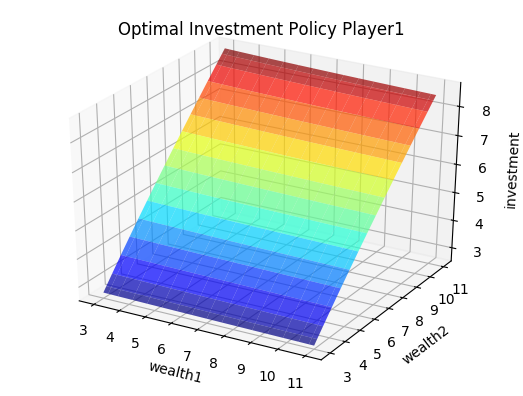

PyObject <matplotlib.text.Text object at 0x13385a310>

In [15]:
# Optimal Policy Player1
surf(xgrid, ygrid, z, cmap=ColorMap("jet"), alpha=0.7)
xlabel("wealth1")
ylabel("wealth2")
zlabel("investment")
title("Optimal Investment Policy Player1")

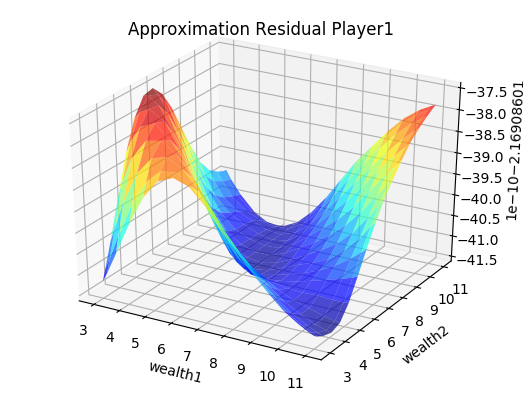

PyObject <matplotlib.text.Text object at 0x133f04dd0>

In [18]:
# Bellman residual
residual = v - vmax(model, S, x, c, e, w)[1]
r = reshape(residual[:, 1], n+2, n+2)
surf(xgrid, ygrid, r, cmap=ColorMap("jet"), alpha=0.7)
xlabel("wealth1")
ylabel("wealth2")
title("Approximation Residual Player1")